<img src="https://www.infocubic.co.jp/en/blog/wp-content/uploads/2018/02/mercari-logo.jpg"/>

<h1><center> Mercari Price Recommendation </center></h1>

## 1. DEFINING THE PROBLEM:

Mercari is an online shopping platform - almost like Craigslist. They would like to offer pricing recommendation to sellers. 

In this __[Kaggle Competition](https://www.kaggle.com/c/mercari-price-suggestion-challenge)__, Mercari is challenging us to **an algorithm that automatically suggests the right product prices**.We are provided with user's description of their products including product details like category name, brand name and item condition.

The recommendation will allow users to price their product appropriately which will there by increase more transaction under Mercari's platform.

We can use both supervised and unsupervised learning approach to solve this problem. We can implement Natural Language Processing, Cluster analysis etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge

## 2. DISCOVERING DATA:

In [2]:
# Observe the training set
train = pd.read_csv('/MercariPriceRecommendation/data/train_1000.tsv', sep = '\t')
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0.0,0,NaN


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 8 columns):
train_id             1001 non-null int64
name                 1001 non-null object
item_condition_id    1001 non-null int64
category_name        997 non-null object
brand_name           583 non-null object
price                1001 non-null float64
shipping             1001 non-null int64
item_description     1000 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 62.6+ KB


In [4]:
train.astype('object').describe().transpose()

,count,unique,top,freq
train_id,1001,1001,1000,1
name,1001,997,Bundle,3
item_condition_id,1001,5,1,453
category_name,997,275,"Women/Athletic Apparel/Pants, Tights, Leggings",44
brand_name,583,229,Nike,38
price,1001,105,10,75
shipping,1001,2,0,549
item_description,1000,936,No description yet,58


In [5]:
print("Number of items without description: "+ str(train.item_description.value_counts()["No description yet"]) )
print("Number of unique brands: "+ str(train.brand_name.nunique()-1) )
print("Most of the item is priced: $"+ str(int(train.price.mode())) )
print("Mean price is: $"+  str(round(train.price.mean(),2)) )
print("Most item are of category:"+ str(train.category_name.mode()) )

Number of items without description: 58
Number of unique brands: 228
Most of the item is priced: $10
Mean price is: $27.77
Most item are of category:0    Women/Athletic Apparel/Pants, Tights, Leggings
dtype: object


In [6]:
##Number of missing values for features:
train.isnull().sum()

train_id               0
name                   0
item_condition_id      0
category_name          4
brand_name           418
price                  0
shipping               0
item_description       1
dtype: int64

In [7]:
#Creating function to replace missing values 
def replace_missing_values(dataset):
    dataset['category_name'].fillna(value = 'Other', inplace=True)
    dataset['brand_name'].fillna(value = 'Unknown', inplace=True)
    dataset['item_description'].fillna(value = 'No description yet', inplace=True)
    return dataset

train = replace_missing_values(train)

####  Exploratory Data Analysis
Our targe variable is price. Lets look nature of this feature more closely:

In [8]:
train.price.describe()

count    1001.000000
mean       27.773227
std        45.848048
min         0.000000
25%        10.000000
50%        16.000000
75%        29.000000
max       650.000000
Name: price, dtype: float64

**Summary of Price feature:**
- Mean price is 27 dollars
- Median price is 16 dollars
- Max price is 650 dollars
- Most items are priced around 10 dollars

Text(0.5, 1.0, 'Price Distribution')

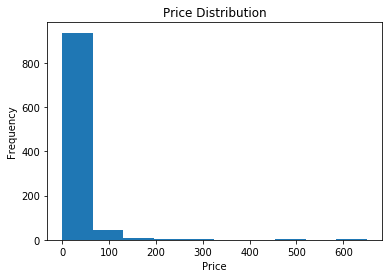

In [9]:
# Plotting Price Distribution
train['price'].plot.hist()
plt.xlabel('Price')
plt.title('Price Distribution')

**Checking prices which are priced 0**

In [10]:
train[train.price==0]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Unknown,0.0,0,No description yet
5,5,Bundled items requested for Ruie,3,Women/Other/Other,Unknown,0.0,0,"Banana republic bottoms, Candies skirt with ma..."


**Removing entries which are priced 0**

Since Mercari is commercial platform, users cannot give away their products for free.

In [11]:
train=train[train.price!=0]

**Applying Log Transformation on Price:**
The price is right skewed - most of the items are priced under $50. To make low price product's error more relevant than high prices, it would be better to use log transformation on prices to make it available for modeling.

Text(0.5, 1.0, 'Log Price Distribution')

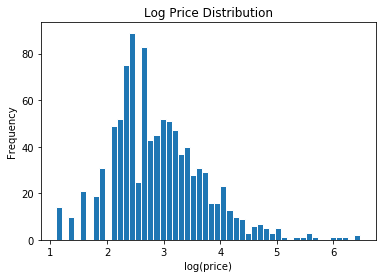

In [12]:
np.log(train['price']).plot.hist(bins=50,edgecolor='white')
plt.xlabel('log(price)')
plt.title('Log Price Distribution')

**Shipping feature:**
Shipping is 1 if shipping fee is paid by seller
Shipping is 0 if shipping fee is paid by buyer

In [13]:
train.shipping.value_counts()

0    547
1    452
Name: shipping, dtype: int64

In [14]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']

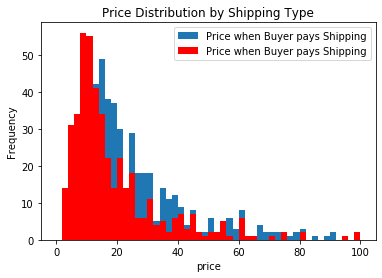

In [15]:
shipping_fee_by_buyer.plot.hist(bins=50,range = [0, 100],label='Price when Buyer pays Shipping')
shipping_fee_by_seller.plot.hist(color='red',bins=50,range = [0, 100],label='Price when Buyer pays Shipping')

plt.xlabel('price')
plt.title('Price Distribution by Shipping Type')
plt.legend()

In [16]:
print("Average price if Buyer has to pay fee: ${}".format(round(shipping_fee_by_buyer.mean(),2)))
print("Average price if Seller has to pay fee: ${}".format(round(shipping_fee_by_seller.mean(),2)))

Average price if Buyer has to pay fee: $31.41
Average price if Seller has to pay fee: $23.49


**Category features:**

Top 10 categories are:

In [17]:
train['category_name'].value_counts()[:10].reset_index()

,index,category_name
0,"Women/Athletic Apparel/Pants, Tights, Leggings",44
1,Women/Tops & Blouses/T-Shirts,32
2,Beauty/Makeup/Lips,27
3,Beauty/Makeup/Face,25
4,Beauty/Makeup/Eyes,25
5,Beauty/Fragrance/Women,19
6,Women/Tops & Blouses/Blouse,17
7,"Electronics/Cell Phones & Accessories/Cases, C...",16
8,Women/Jewelry/Necklaces,14
9,Women/Shoes/Boots,13


**New features from Category features:**

We can see that Category has Main and sub-cateogries. We can create new features out of this.

In [18]:
def split_category(category_name):
    try:
        main,sub_cat1,sub_cat2=category_name.split('/')
        return main,sub_cat1,sub_cat2
    except:
        return 'Other','Other','Other'

In [19]:
train['main_category'], train['sub_category1'], train['sub_category2'] =  zip(*train['category_name'].apply(split_category))

cat_train = train[['main_category','sub_category1','sub_category2', 'price']]

cat_train.head()

,main_category,sub_category1,sub_category2,price
0,Men,Tops,T-shirts,10.0
1,Electronics,Computers & Tablets,Components & Parts,52.0
2,Women,Tops & Blouses,Blouse,10.0
3,Home,Home Décor,Home Décor Accents,35.0
6,Women,Swimwear,Two-Piece,64.0


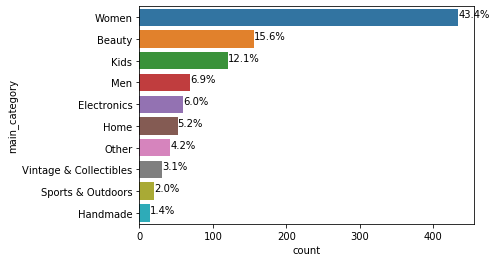

In [20]:
ax = sns.countplot(y ="main_category", data=cat_train, order = cat_train['main_category'].value_counts().index)
total = len(cat_train['main_category'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

We can see that the top three main categories are Women,Beauty and Kids.

Women products take 43.4% of the items sold, followed by 15.6% of it are Beauty products and 12% are Kid's product

**Brand Analysis:**

In [21]:
#Unique brands - Unknown brands
train.brand_name.nunique()-1

229

There are 229 unique brands.

**Frequent Brands:**

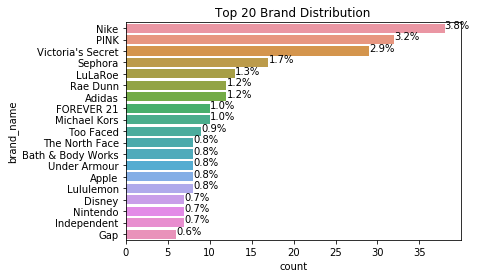

In [22]:
brnd = sns.countplot(y ="brand_name", data=train, order = train['brand_name'].value_counts()[1:20].index)
total_brand = len(train['brand_name'])
for p in brnd.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        brnd.annotate(percentage, (x, y))
brnd.set_title('Top 20 Brand Distribution')
plt.show()

Nike, PINK, Vicotria's Secret are frequent brands sold in Mercari.

**Expensive Brands in Mercari:**

In [23]:
top_10_exp_brand = pd.DataFrame(
    train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:10]).reset_index()
top_10_exp_brand.head()

,brand_name,price
0,Samsung,267.993470
1,Burberry,218.175006
2,Air Jordan,112.784455
3,Xbox,101.739455
4,Spin Master,69.296465


Text(0.5, 1, 'Top 10 Expensive Brands Distribution')

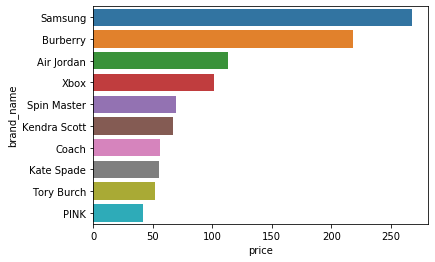

In [24]:
exp_brnd = sns.barplot(x="price", y="brand_name", data=top_10_exp_brand)
brnd.set_title('Top 10 Expensive Brands Distribution')

Samsung is most Expensive Brand followed by Burberry and Jordan.

<h2><center>Text Analysis</center></h2>
<img src='https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/07/performing-twitter-sentiment-analysis1.jpg'>


**Text Processing:**
Since we're working with Text Features, we're going to:
- Tokenize
- Stemming
- Vectorize
- Remove Stop words & punctuations
- Check relationship between price and word count in description

**Text Length vs Price:**

In [25]:
train.item_description = train.item_description.astype(str)
train['wordcount']  = train.item_description.str.len()
descr = train[['name','item_description', 'price','wordcount']]
descr.head()

,name,item_description,price,wordcount
0,MLB Cincinnati Reds T Shirt Size XL,No description yet,10.0,18
1,Razer BlackWidow Chroma Keyboard,This keyboard is in great condition and works ...,52.0,188
2,AVA-VIV Blouse,Adorable top with a hint of lace and a key hol...,10.0,124
3,Leather Horse Statues,New with tags. Leather horses. Retail for [rm]...,35.0,173
6,Acacia pacific tides santorini top,Size small but straps slightly shortened to fi...,64.0,83


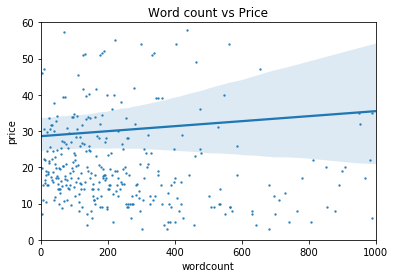

In [26]:
df = descr.groupby('wordcount')['price'].mean().reset_index()
countplot = sns.regplot(x=df["wordcount"], y=(df["price"]),scatter_kws={'s':2}).set(xlim=(0,1000),ylim=(0,60))
plt.title("Word count vs Price")
plt.show()

There is somewhat linear relationship between word count and price. Looks like more words for a product relates to more price.
We can review this further down.

We can normalize the text in description by removing punctuation ,removing stop words, lowercasing the words, stemming the words

**Punctuations:**

We can replace punctuations by no text

In [27]:
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [28]:
# Create a list of punctuation replacements
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
    
punctuation_symbols[:5]

[('!', ''), ('"', ''), ('#', ''), ('$', ''), ('%', '')]

**Stop Words:**

We can remove the stopwords (super common words in English).

In [29]:
#import nltk
#nltk.download('stopwords')
# Examine list of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop[:5]

['i', 'me', 'my', 'myself', 'we']

In [30]:
import string

# Create a function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Create a function to remove stop words
def remove_stopwords(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Create a function to lowercase the words
def lowercase(x):
    return x.lower()

In [31]:
#Removing punctuation,stopwords and lowering the case for item description
train['item_description'] = train['item_description'].apply(remove_punctuation)
train['item_description'] = train['item_description'].apply(remove_stopwords)
train['item_description'] = train['item_description'].apply(lowercase)

train['name'] = train['name'].apply(remove_punctuation)
train['name'] = train['name'].apply(remove_stopwords)
train['name'] = train['name'].apply(lowercase)

**Stemming:**

We can stem words to cluster words which have same meaning. For example: swim,swam,swimming etc. are of same thing from root word 'swim'

In [32]:
# Stem the Words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
train['item_description'] = train['item_description'].apply(porter.stem)

In [33]:
# Examining the normalized item description
train['item_description'][1:10]

1     keyboard great condition works like came box p...
2     adorable top hint lace key hole back pale pink...
3     new tags leather horses retail rm stand foot h...
6     size small straps slightly shortened fit xs be...
7     get three pairs sophie cheer shorts size small...
8          girls size small plus green three shorts tot
9     realized pants backwards picture dirty hand wa...
10                      025 oz full size 1oz rm sephora
11    5 new vs pink body mists 25 oz fresh  clean su...
Name: item_description, dtype: object

**Tokenize:**

Split each text into words (bag of words model)

In [34]:
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

text1 = train['item_description'][1]
tokens = word_tokenize(text1)
print(tokens)

['keyboard', 'great', 'condition', 'works', 'like', 'came', 'box', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'via', 'razer', 'synapse', 'app', 'pc']


<h3><center> Feature Extraction from Text </center></h3>
<img src=https://miro.medium.com/max/2120/0*FsV8kv3l5Mo-kizd.jpg style="width: 500px;"/>

**Bag of Words:**: creating a feature for each word. We lose word ordering this way. 
**n-gram:**  Highlights and captures important parts of text with smaller frequencies of texts. 
         This preserves local ordering and can improve model performance.
To preserve some ordering, we can introduce **n-grams** into our vectorization of words (problem: too many features)


**Word Frequency Weights:**
Each word in description have different frequency
- Frequency Weight
- TF-IDF Weight
- Vectorization
- LabelBinarizer

**CountVectorizer**: 

Returns an encoded vector with integer count for each word

In [35]:
# CountVectorizer - name & categories
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(train['name'])
X_category_main = cv.fit_transform(train['main_category'])
X_category_sub1 = cv.fit_transform(train['sub_category1'])
X_category_sub2 = cv.fit_transform(train['sub_category2'])
print("Item Name Shape: " + str(X_name.shape))
print("Main Category Shape: " + str(X_category_main.shape))
print("Sub Category1 Shape: " + str(X_category_sub1.shape))
print("Sub Category2 Shape: " + str(X_category_sub2.shape))

Item Name Shape: (999, 53)
Main Category Shape: (999, 12)
Sub Category1 Shape: (999, 43)
Sub Category2 Shape: (999, 48)


**LabelBinarizer:**

 Gets all tokens(individual words) and assigns its own column. 
 0 means the description does not have the word and 1 means it has.

In [36]:
# Apply LabelBinarizer to "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(train['brand_name'])
print("Item Brand Shape: " + str(X_brand.shape))

Item Brand Shape: (999, 230)


**Get Dummies:**

This will convert categorical features to indicators (separate feature for each choice)

In [37]:
# Apply get_dummies to "item_condition_id" and "shipping" and then convert into a CSR Matrix
X_dummies = csr_matrix(pd.get_dummies(train[['item_condition_id', 'shipping']], sparse=True).values)

**TFIDF:**
#Term Frequency Inverse Document Frequency
It measures how important a word or phrase is within a collection of documents. 
It essentially weighs down term that appear frequently and scales up unique terms.

TF Term Frequency: how often a term occurs in a document

IDF Inverse Document Frequency: how many documents contains the word or how important a term is

In [38]:
# Perform a TFIDF Transformation of the item description with the top 15000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(train['item_description'])
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (999, 15000)


In [39]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

# Lowest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=True).head()

,tfidf
new,2.203973
size,2.362578
brand,2.877317
brand new,2.995100
condition,3.079442


In [40]:
# Highest TFIDF Scores
tfidf.sort_values(by=['tfidf'], ascending=False).head()

,tfidf
00,7.214608
primers,7.214608
prices typically,7.214608
pricing,7.214608
pricing firm,7.214608


In [41]:
# Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_brand, X_name, X_category_main, X_category_sub1, X_category_sub2)).tocsr()

<h3><center> Topic Modeling | LDA - Latent Dirichlet Allocation </center></h3>
<img src=https://miro.medium.com/max/1935/1*_ZMgTsJGmR743ngZ7UxN9w.png style="width: 300px;"/>

**LDA:**

Great technique to explore data and underdstand if there is relevant word pairing for a topic. It is unsupervised learning method. It is useful for:
    - Text classification (groups similar words in a topic)
    - Recommender systems (recommend articles or any suggestion based on previous texts)
    - Uncovering themes in texts (detect trends in set of texts)

LDA Steps:
1. Word is assigned to random topic.
2. Probability of word belonging to a topic is considered. 
3. Probability of document generating a topic is considered. (Each topic in a document are percentages that all add up to 1.)
4. The word is reassigned to a topic based on probablities in 2 and 3
5. Algorithm iterates through each word for 1-4

In [76]:
X_train = train.reset_index(drop=True)
y_train = np.log1p(X_train['price'])

In [77]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000, stop_words='english', lowercase=True)

# Fit it to our dataset
cvz = cvectorizer.fit_transform(X_train['item_description'])

# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: new | brand | size | ship | price | firm | free | bundle | box | shipping
Topic 1: size | free | new | shipping | worn | item | good | brand | white | used
Topic 2: new | brand | rm | free | size | used | box | worn | eyebrow | pink
Topic 3: rm | size | condition | new | great | cute | worn | super | pink | bundle
Topic 4: size | new | brand | worn | condit | small | condition | color | great | black
Topic 5: size | comes | cute | box | used | different | condition | bundle | dont | free
Topic 6: size | brand | new | brush | like | worn | set | tags | item | 2ml
Topic 7: size | new | free | shipping | condition | used | color | zip | great | brand
Topic 8: description | slime | black | old | great | best | used | snags | play | bundle
Topic 9: condition | rm | worn | size | bundle | price | shipping | good | free | ship
Wall time: 1.34 s


https://miro.medium.com/max/2000/1*8oyYVEo_N2jGfYRXYW3HWA.png


<h3><center> Eli5</center></h3>
<img src=https://steemitimages.com/640x0/https://cdn.steemitimages.com/DQmev4Exy7kYThVzpvfSy1AUZRZdgvn16QjkvRrKhSRE36K/ELI5%20explain%20it%20like%20im%20five.png style="width: 500px;"/>

**Eli5  – Explain it Like I'm 5:**

Library that allows you to see what the model has learnt from the text features which in turn help understand how the classifier works. Eli5 helps to notice preprocessing bugs, data leaks, issues with task specification

Eli5 shows the correlation of each feature/text with the target variable. 
We can inspect features and weights because we’re using a bag-of-words vectorizer and a linear classifier (so there is a direct mapping between individual words and classifier coefficients). 

**Analyzing Item Description with Eli5:**

In [78]:
# Definte RMSLE Cross Validation Function
def rmsle_cv(model):
    kf = KFold(shuffle=True, random_state=42).get_n_splits(X_train['item_description'])
    rmse= np.sqrt(-cross_val_score(model,X_train['item_description'], 
                                   y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse.mean())

In [91]:
from sklearn.linear_model import Ridge

vec = CountVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['item_description'],y_train)

cv_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_rmsle))
import eli5
eli5.show_weights(pipe, vec=vec, top=5, feature_filter=lambda x: x != '<BIAS>')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.8268294879795429


In [92]:
eli5.show_prediction(clf, doc=X_train['item_description'][200], vec=vec)

**Baseline model with CountVecorizer and Stopwords**

In [93]:
vec = CountVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['item_description'], y_train)

cv_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_sw_rmsle))
eli5.show_prediction(clf, doc=X_train['item_description'][200], vec=vec)

The Validation Score is: 0.8124113263397502


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


**Baseline model with CountVecorizer and Stopwords**

In [94]:
vec = TfidfVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['item_description'], y_train)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))
eli5.show_prediction(clf, doc=X_train['item_description'][200], vec=vec)

The Validation Score is: 0.7405546309322677


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


**Baseline model with TFIDF**

In [103]:
vec = TfidfVectorizer()
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['item_description'], y_train)

tfidf_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_rmsle))
eli5.show_prediction(clf, doc=X_train['item_description'][200], vec=vec)

The Validation Score is: 0.7426035849503938


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


**Baseline model with TFIDF and stopwords**

In [104]:
vec = TfidfVectorizer(stop_words='english')
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['item_description'], y_train)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))
eli5.show_prediction(clf, doc=X_train['item_description'][200], vec=vec)

The Validation Score is: 0.7405546309322677


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


**Baseline Model with TF-IDF, Stop Words, and N-Grams**

In [105]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge(random_state=42)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train['item_description'], y_train)

tfidf_sw_ng_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))
eli5.show_prediction(clf, doc=X_train['item_description'][200], vec=vec)

The Validation Score is: 0.7370564532441065


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:431: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


**RSMLE Summary:**

In [106]:
print ("RMSLE Score: " + str(cv_rmsle) + " | CountVectorizer")
print ("RMSLE Score: " + str(cv_sw_rmsle) + " | CountVectorizer | Stop Words")
print ("RMSLE Score: " + str(tfidf_rmsle) + " | TF-IDF")
print ("RMSLE Score: " + str(tfidf_sw_rmsle) + " | TF-IDF | Stop Words")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle) + " | TF-IDF | Stop Words | N-Grams")

RMSLE Score: 0.8268294879795429 | CountVectorizer
RMSLE Score: 0.8124113263397502 | CountVectorizer | Stop Words
RMSLE Score: 0.7426035849503938 | TF-IDF
RMSLE Score: 0.7405546309322677 | TF-IDF | Stop Words
RMSLE Score: 0.7370564532441065 | TF-IDF | Stop Words | N-Grams


 TF-IDF | Stop Words | N-Grams combination works best.

**Feature Pre-processing and Transformation:** 

It's super modular.
So you have an estimator or a transformer, then you have a pipeline, then you connect more than one transformations together

In [137]:
from sklearn.pipeline import FeatureUnion

default_preprocessor = CountVectorizer().build_preprocessor()

def build_preprocessor(field):
    field_idx = list(X_train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])

vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name')))
])

**Creating Transformed Set**

In [138]:
# Create Transformed Train Set
Xt_train = vectorizer.fit_transform(X_train.values)
Xt_train

<999x5039 sparse matrix of type '<class 'numpy.int64'>'
	with 9024 stored elements in Compressed Sparse Row format>

**RSMLE:**

Used to penalize lower errors

In [140]:
def get_rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))

**Ridge Model:**

In [180]:
%%time

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(Xt_train):
    # Define Ridge Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=False, random_state=42)
    
    # Fit Ridge Model
    model_ridge.fit(Xt_train[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    print(f'Ridge Training RMSLE: {rmsle_train:.5f}')
    print(f'Ridge Validation RMSLE: {rmsle_valid:.5f}')


Ridge Training RMSLE: 0.23366
Ridge Validation RMSLE: 1.28373
Ridge Training RMSLE: 0.21490
Ridge Validation RMSLE: 1.35464
Ridge Training RMSLE: 0.21607
Ridge Validation RMSLE: 1.56764
Wall time: 39.1 ms


**Lasso Cross Validation:**

In [181]:
%%time
from sklearn.linear_model import Lasso

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(Xt_train):
    # Define Lasso Model
    model_LASSO = Lasso(fit_intercept=True, random_state=42)
    
    # Fit Lasso Model
    model_LASSO.fit(Xt_train[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_LASSO.predict(Xt_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_LASSO.predict(Xt_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    print(f'LASSO Training RMSLE: {rmsle_train:.5f}')
    print(f'LASSO Validation RMSLE: {rmsle_valid:.5f}')


LASSO Training RMSLE: 0.78040
LASSO Validation RMSLE: 0.74633
LASSO Training RMSLE: 0.78205
LASSO Validation RMSLE: 0.74436
LASSO Training RMSLE: 0.74363
LASSO Validation RMSLE: 0.81930
Wall time: 55.6 ms


**LGBM Model**

In [161]:
%%time
import lightgbm as lgb

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for train_ids, valid_ids in cv.split(Xt_train):
    # Define LGBM Model
    model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit LGBM Model
    model_lgb.fit(Xt_train[train_ids].astype('float32'), y_train[train_ids].astype('float32'))
    
    # Predict & Evaluate Training Score
    y_pred_train = model_lgb.predict(Xt_train[train_ids].astype('float32'))
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids].astype('float32'))
    

    # Predict & Evaluate Validation Score
    y_pred_valid = model_lgb.predict(Xt_train[valid_ids].astype('float32'))
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids].astype('float32'))
    
    print(f'LGBM Training RMSLE: {rmsle_train:.5f}')
    print(f'LGBM Validation RMSLE: {rmsle_valid:.5f}')
    

LGBM Training RMSLE: 0.73725
LGBM Validation RMSLE: 0.71766
LGBM Training RMSLE: 0.74415
LGBM Validation RMSLE: 0.71365
LGBM Training RMSLE: 0.69026
LGBM Validation RMSLE: 0.79938
Wall time: 647 ms


**Ensemble Lasso and LGBM**

In [162]:
# Train and Test Split
train_X, test_X, train_y, test_y = train_test_split(Xt_train, y_train, test_size=0.2, random_state=144)

In [165]:
# Define LGBM Model
model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)

# Fit LGBM Model
model_lgb.fit(train_X.astype('float32'), train_y.astype('float32'))

# Predict with LGBM Model
lgbm_y_pred = model_lgb.predict(test_X.astype('float32'))

In [184]:
# Define Ridge Model
model_ridge = Ridge(fit_intercept=False, random_state=42)
    
# Fit Ridge Model
model_ridge.fit(train_X, train_y)
    
# Evaluate Training Score
ridge_y_pred = model_ridge.predict(test_X)

In [187]:
#Ensemble Model

ensemble_y_pred = (lgbm_y_pred+ridge_y_pred)/2

ensemble_rmsle = get_rmsle(ensemble_y_pred, test_y)

print(f'Ensemble RMSLE: {ensemble_rmsle:.5f}')

Ensemble RMSLE: 1.01875


**Predictions:**

In [188]:
#Ensemble prediction w/o inverse:
ensemble_y_pred[0:20]

array([3.01319055, 2.04111355, 3.2837384 , 1.79162713, 2.7978775 ,
       2.16972323, 2.23058263, 2.67454339, 1.87007174, 2.69440384,
       3.31977994, 3.12946561, 2.86360255, 2.87249268, 2.60153834,
       2.15029589, 2.70047331, 2.77910866, 4.24846241, 2.31721563])

In [193]:
#Recommendation Prices from the model
# Esenmble Predictions
ensemble_y = (np.expm1(lgbm_y_pred)+np.expm1(ridge_y_pred))/2
ensemble_y[:10]

array([19.6970456 ,  9.83664648, 25.68234631, 10.59346922, 15.4351133 ,
       11.53877253,  9.55051304, 14.64722771, 10.73555209, 14.84538018])

In [192]:
# Test Predictions 
np.expm1(test_y[:10])

656    36.0
121     8.0
315    44.0
238     3.0
388     3.0
792    28.0
295    18.0
104    41.0
276    12.0
760    18.0
Name: price, dtype: float64